In [12]:
import os
import sys
import numpy as np
import pandas as pd

from matplotlib import cm, pyplot as plt
# Change plot style to ggplot (for more aesthetic visualisation)
plt.style.use('ggplot')
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(18, 6)

# Supress warning in hmmlearn
import warnings
warnings.filterwarnings("ignore")

# Read the stock data
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [13]:
start = pd.to_datetime('2007-01-01').date() # datetime.datetime(2010, 1, 1)
end = pd.to_datetime('2019-04-01').date() # datetime.datetime(2018, 12, 31)
df = web.DataReader('GOOG', 'yahoo', start, end)
# df.columns = [col.lower() for col in df.columns]
data = df.sort_index(ascending=True, axis=0).reset_index()
df.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,236.789917,229.065155,231.494354,232.284210,15513200.0,232.284210
2007-01-04,240.411362,232.661758,232.984665,240.068588,15877700.0,240.068588


In [14]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [20]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

In [15]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 99s - loss: 2.2353e-04


In [16]:
rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

62.10702545676047


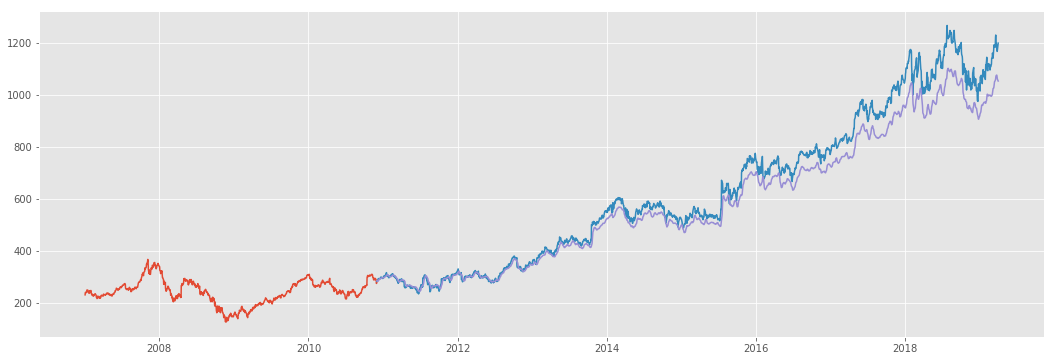

In [19]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.show()